In [1]:
import seaborn as sns

In [2]:
import sklearn

In [3]:
import pandas as pd

In [130]:
from src.utils import save_checkpoint

In [4]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [5]:
import torch

In [6]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import glob
import tqdm
from torch.utils.tensorboard import SummaryWriter


In [7]:
def read_label_data(label):
    images = glob.glob(f"data_clean/{label}/*.jpg")
    data = []
    for image in tqdm.tqdm(images, ascii=False):
        img2 = cv.imread(image)
        data.append({"image": img2, "label": label})
    return data

In [8]:
A = read_label_data("A")

100%|██████████| 180/180 [00:00<00:00, 234.14it/s]


In [9]:
B = read_label_data("B")
C = read_label_data("C")
D = read_label_data("D")
E = read_label_data("E")
UNKNOWN = read_label_data("UNKNOWN")

100%|██████████| 51/51 [00:00<00:00, 74.53it/s]


In [10]:
training_data = A + B + C + D + E + UNKNOWN

In [11]:
training_data_labels = [e['label'] for e in training_data]

In [12]:
weights = class_weight.compute_class_weight("balanced", classes=np.unique(training_data_labels), y=training_data_labels)

In [13]:
train_clean, test_clean = train_test_split(training_data, test_size=0.4, stratify=training_data_labels)

In [14]:
import torch
from torch import nn
import torchvision

In [15]:
class NutriNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.resnet = torchvision.models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.resnet.fc = nn.Linear(512, 6)
        
    def forward(self, x):
        return self.resnet(x)

In [16]:
from albumentations import Resize, PadIfNeeded, ElasticTransform, GaussianBlur,RandomRotate90, Compose, Transpose, Normalize, RandomBrightness,HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomGamma, RandomContrast, OneOf


In [134]:
class NutriDataset(torch.utils.data.Dataset):
    def __init__(self, items, val=False):
        self.items = items
        self._label_map = {
            "UNKNOWN": 0,
            "A": 1,
            "B": 2,
            "C": 3,
            "D": 4,
            "E": 5
        }
        self._basic_aug = Compose([
            Normalize(),
            Resize(224, 224),
#                 PadIfNeeded(min_height=224, min_width=224)
        ])
        self._val = val
        self._aug = Compose([
            Normalize(),
            Resize(224, 224),
            GaussianBlur(),
            VerticalFlip(),
            HorizontalFlip(),
#             RandomGamma(), 
            RandomRotate90(),
#             RandomContrast(), 
            ElasticTransform(),
        ])


    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]
        aug = self._basic_aug if self._val else self._aug
        image = aug(image=item['image'])['image']
        image = torch.from_numpy(image).float().permute([2, 0, 1])
        num_label = self._label_map[item['label']]
        label = torch.LongTensor([num_label])
        return image, label

In [135]:
train_dataset = NutriDataset(items=train_clean)
test_dataset = NutriDataset(items=test_clean, val=True)

In [136]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0, shuffle=True)

In [96]:
def trainable_params(model):
        return [p for p in model.parameters() if p.requires_grad]

class Trainer():
    def __init__(self, net, config, writer, weights):
        super().__init__()
        net.to(config['DEVICE'])
        self.net = net
        self.device = config['DEVICE']
        self.config = config
        self.optimizer = torch.optim.Adam(trainable_params(net), lr=config['LR'], weight_decay=config['L2'])
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'max', 
                    threshold=0.004, min_lr=1e-6,
                    factor=0.1, patience=10,
                    verbose=True)
        self.weights = weights
        self.loss = nn.CrossEntropyLoss(weight=torch.from_numpy(weights).float())
        self.losses = []
        self.epoch = 0
        self.global_iteration = 0
        self.writer = writer

    def run(self, dataloader, name="train"):
        self.net.train()
        for idx, (image, label) in enumerate(tqdm.tqdm(dataloader, desc="Training", ascii=True)):
            image, label = image.to(self.device), label.to(self.device)
            self.optimizer.zero_grad()
            predict = self.net(image)
            loss = self.loss(predict, label[:, 0])
            loss.backward()
            self.writer.add_scalar(f"BatchLoss/{name}", loss.item(), global_step=self.global_iteration)
            
            self.losses.append(loss.item())
            self.optimizer.step()
            self.global_iteration += 1
            if self.config['DEBUG'] == True:
                break
        
        self.writer.add_scalar(f"EpochLoss/{name}", np.mean(self.losses), global_step=self.epoch)
        # save_checkpoint(self.net, {"epoch": self.epoch}, "{}-net.pth".format(self.epoch))
        self.epoch += 1

In [97]:
class Evaluation():
    def __init__(self, net, config, writer, weights):
        super().__init__()
        net.to(config['DEVICE'])
        self.weights = weights
        
        
        self.net = net
        self.device = config['DEVICE']
        self.config = config
        self.scores = []
        self.predicted = []
        self.gts = []
        self.epoch = 0
        self.global_iteration = 0
        self.writer = writer

    def run(self, dataloader, name="train"):
        self.net.eval()
        self.gts = []
        self.predicted = []
        self.scores=[]
        with torch.no_grad():
            for idx, (image, label) in enumerate(tqdm.tqdm(dataloader, desc="Evaluation", ascii=True)):
                image, mask = image.to(self.device), label.to(self.device)
                predict = self.net(image)
                predicted_labels = torch.argmax(predict, dim=1).cpu().numpy()
                gt_labels = label.cpu().numpy()[:, 0]
                self.predicted.extend(predicted_labels)
                self.gts.extend(gt_labels)
                weights_dict = {l:w for l, w in enumerate(self.weights) if l in gt_labels}
                sample_weights = class_weight.compute_sample_weight(weights_dict, gt_labels)
                score = f1_score(gt_labels, predicted_labels, average="weighted", sample_weight=sample_weights)
                self.writer.add_scalar(f"BatchF1/{name}", score, global_step=self.global_iteration)
                self.scores.append(score)
                self.global_iteration += 1
                if self.config['DEBUG'] == True:
                    break
            
            mean_score = np.mean(self.scores)
            self.writer.add_scalar(f"F1/{name}", mean_score, global_step=self.epoch)
            cm = confusion_matrix(self.gts, self.predicted, labels=[0, 1, 2, 3, 4, 5])
            plt.figure()
            fig = sns.heatmap(cm, annot=True, fmt="d").get_figure()
            self.writer.add_figure(f"CM/{name}", fig, self.epoch)
            self.epoch += 1
            return mean_score

In [112]:
net = NutriNet()

In [137]:
writer = SummaryWriter(flush_secs=30)

In [138]:
config = {"DEVICE": "cpu", 'LR': 0.00001, "L2": 0.00000, "DEBUG": False}

In [139]:
trainer = Trainer(net, config, writer, weights)

In [140]:
evaluator = Evaluation(net, config, writer, weights)

In [128]:
for param in net.resnet.parameters():
    param.requires_grad = True

In [133]:
# save_checkpoint(net, {"val": 0.91}, "v2.pth", "")

Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 0 = Train score: 0.9640867334571378 | Val Score 0.9026935459779758


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1 = Train score: 0.9460822607999076 | Val Score 0.9041480133733246


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 2 = Train score: 0.9566847980591782 | Val Score 0.9160111771599233


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 3 = Train score: 0.9493810783289232 | Val Score 0.9121955166100884


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 4 = Train score: 0.9706386642877374 | Val Score 0.9101940371266436


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 5 = Train score: 0.9656252646676508 | Val Score 0.9165267698390328


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 6 = Train score: 0.9521942948381151 | Val Score 0.917047995803894


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 7 = Train score: 0.9726994746539723 | Val Score 0.8953694636073833


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 8 = Train score: 0.9541466722971127 | Val Score 0.8922515903945567


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 9 = Train score: 0.9648362458796786 | Val Score 0.9162307541254067


Evaluation: 100%|##########| 11/11 [00:29<00:00,  2.69s/it]
/Users/sasha/.pyenv/versions/3.7.8/envs/healthypicks/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 10 = Train score: 0.9774128340010875 | Val Score 0.920637781149851


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 11 = Train score: 0.9753052151649997 | Val Score 0.9181258641560763


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 12 = Train score: 0.9583282241436181 | Val Score 0.9240729457016323


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 13 = Train score: 0.9464332361854634 | Val Score 0.9195231720360686


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 14 = Train score: 0.9622284705965183 | Val Score 0.9203695574601503


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 15 = Train score: 0.9654519038952664 | Val Score 0.9167781377275559


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 16 = Train score: 0.9669380547299844 | Val Score 0.9220673579183201


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 17 = Train score: 0.9763666059935363 | Val Score 0.922279251459407


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 18 = Train score: 0.9741291121616444 | Val Score 0.9204627936845362


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 19 = Train score: 0.9707348474084266 | Val Score 0.924416953159459


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 20 = Train score: 0.9724841725188235 | Val Score 0.9258979600915518


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 21 = Train score: 0.9661203850604898 | Val Score 0.9069404632158489


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 22 = Train score: 0.9734015141275187 | Val Score 0.9247160228186133


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 23 = Train score: 0.9708887416726683 | Val Score 0.9201641324289778


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 24 = Train score: 0.9774448242235004 | Val Score 0.9194832698199064


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 25 = Train score: 0.9732629784717641 | Val Score 0.9100937833552498


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 26 = Train score: 0.9808195315171203 | Val Score 0.923541341474333


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 27 = Train score: 0.9580032365180986 | Val Score 0.9167060364751485


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 28 = Train score: 0.9817093387713466 | Val Score 0.9179047750406689


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 29 = Train score: 0.9876176593502906 | Val Score 0.9173845035584316


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 30 = Train score: 0.9756101290883741 | Val Score 0.905493401498396


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 31 = Train score: 0.982731935840663 | Val Score 0.9000404905040557


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 32 = Train score: 0.9793825078819108 | Val Score 0.9053119737123412


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 33 = Train score: 0.979377654689515 | Val Score 0.907182932117141


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 34 = Train score: 0.9858131340660765 | Val Score 0.9052031695079021


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 35 = Train score: 0.9710741600066073 | Val Score 0.9084374023927742


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 36 = Train score: 0.9913780824226758 | Val Score 0.9163922552290769


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 37 = Train score: 0.9622751445800449 | Val Score 0.8947670423283022


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 38 = Train score: 0.9782901558528869 | Val Score 0.9172103858457654


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 39 = Train score: 0.9710772139188812 | Val Score 0.875875915663624


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 40 = Train score: 0.9879122150902375 | Val Score 0.8853540553541057


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 41 = Train score: 0.9624887422175558 | Val Score 0.9113327208404023


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 42 = Train score: 0.9862061396247821 | Val Score 0.9259525566439148


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 43 = Train score: 0.99617833999753 | Val Score 0.923995552067283


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 44 = Train score: 0.9748345428863274 | Val Score 0.8827501723876163


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 45 = Train score: 0.9879283482976585 | Val Score 0.904691757927263


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 46 = Train score: 0.9841858898896017 | Val Score 0.9181316666496033


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 47 = Train score: 0.9771070910910911 | Val Score 0.9237041333305755


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 48 = Train score: 0.9814265363013781 | Val Score 0.9253163995204525


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 49 = Train score: 0.9919143033795222 | Val Score 0.9243914624045458


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 50 = Train score: 0.9924787681813686 | Val Score 0.9177105773844523


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 51 = Train score: 0.9711554508036532 | Val Score 0.8980215000148214


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 52 = Train score: 0.9902733128688864 | Val Score 0.9073116741807912


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 53 = Train score: 0.9855477525201347 | Val Score 0.9143265802839948


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 54 = Train score: 0.95705602280749 | Val Score 0.9101029855587524


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 55 = Train score: 0.9778274261477364 | Val Score 0.9158877171499957


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 56 = Train score: 0.9727278846126702 | Val Score 0.9209812336296769


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 57 = Train score: 0.9862742881951589 | Val Score 0.9086962367064719


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 58 = Train score: 0.9817418479181735 | Val Score 0.9286607566055989


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 59 = Train score: 0.9756979756009341 | Val Score 0.9234761659167231


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 60 = Train score: 0.9763745128939001 | Val Score 0.9278726670807398


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 61 = Train score: 0.9814470312555431 | Val Score 0.9084329078756728


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 62 = Train score: 0.9862902777933652 | Val Score 0.9078688053534929


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 63 = Train score: 0.9978747763618953 | Val Score 0.8880542246936928


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 64 = Train score: 0.9807015733596901 | Val Score 0.9250753185871622


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 65 = Train score: 0.9815869483720328 | Val Score 0.908465531163026


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 66 = Train score: 0.9936385266622859 | Val Score 0.923728976159458


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 67 = Train score: 0.9817789858600712 | Val Score 0.9062373324356937


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 68 = Train score: 0.9910943235533464 | Val Score 0.9308538152408449


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 69 = Train score: 0.9852852808190683 | Val Score 0.9007609199412285


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 70 = Train score: 0.9688943200710625 | Val Score 0.9271290111287738


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 71 = Train score: 0.985162305982803 | Val Score 0.9286577397517827


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 72 = Train score: 0.982606430505579 | Val Score 0.9194546184901209


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 73 = Train score: 0.9893990248746217 | Val Score 0.8737922364050507


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 74 = Train score: 0.9814435919885444 | Val Score 0.9239335834530253


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 75 = Train score: 0.9937545071859734 | Val Score 0.9277430332495511


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 76 = Train score: 0.9844887486751219 | Val Score 0.9244857507353494


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 77 = Train score: 0.9969088582943377 | Val Score 0.9082111100092782


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 78 = Train score: 0.9958271627284353 | Val Score 0.9221104222005265


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 79 = Train score: 0.9895939596428017 | Val Score 0.9139593493422925


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 80 = Train score: 0.979385677981299 | Val Score 0.884720208015882


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 81 = Train score: 0.9762607720941248 | Val Score 0.9192148566516168


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 82 = Train score: 0.9910003360354498 | Val Score 0.9321384369495024


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 83 = Train score: 0.9852340912990514 | Val Score 0.9249652575643982


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 84 = Train score: 0.9769703158392457 | Val Score 0.9361626606701223


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 85 = Train score: 0.9864097572410718 | Val Score 0.9150068469893275


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 86 = Train score: 0.994430340084288 | Val Score 0.9291096258910715


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 87 = Train score: 0.9830226417614564 | Val Score 0.9263466911772442


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 88 = Train score: 0.9809213335196373 | Val Score 0.9178205785984699


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 89 = Train score: 0.9934866992761147 | Val Score 0.9340652549082052


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 90 = Train score: 0.9913202601532994 | Val Score 0.9347706251519954


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 91 = Train score: 0.9863786451490355 | Val Score 0.9048832137486678


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 92 = Train score: 0.9917495188136226 | Val Score 0.9281203159012987


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 93 = Train score: 0.9860533578502987 | Val Score 0.9268745088826447


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 94 = Train score: 0.9849327407241144 | Val Score 0.9142907914484562


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 95 = Train score: 0.9872795500465892 | Val Score 0.8988233538076325


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 96 = Train score: 0.9876274776909791 | Val Score 0.8920402406760647


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 97 = Train score: 0.9934752640385184 | Val Score 0.9042374055821905


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 98 = Train score: 0.9854975470085026 | Val Score 0.9142999790661955


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 99 = Train score: 0.986623141755521 | Val Score 0.9234448548002134


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 100 = Train score: 0.9874472163795063 | Val Score 0.9174552739083195


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 101 = Train score: 0.9850462772762857 | Val Score 0.926683004045722


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 102 = Train score: 0.9966271048002152 | Val Score 0.9258719247287674


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 103 = Train score: 0.9921648601382536 | Val Score 0.911583554382602


Training:  64%|######3   | 7/11 [00:51<00:29,  7.40s/it]


KeyboardInterrupt: 

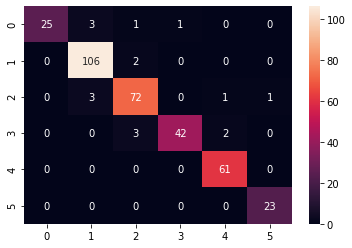

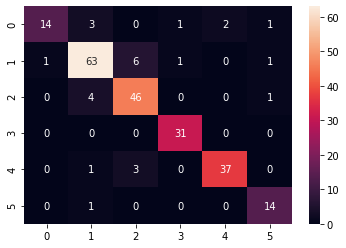

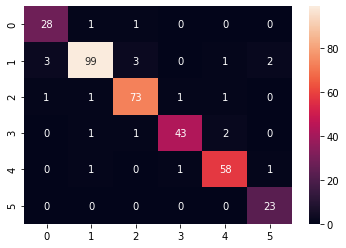

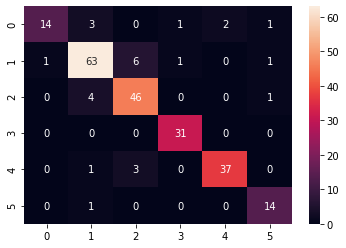

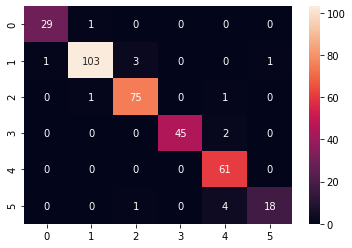

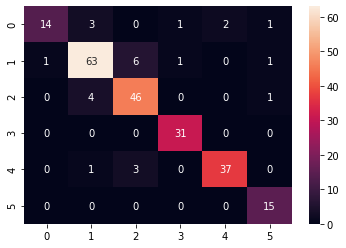

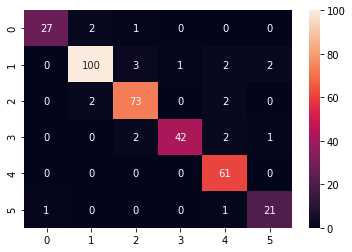

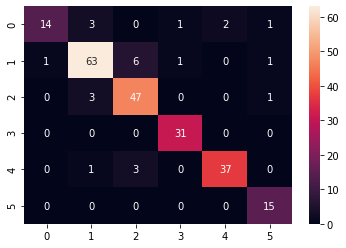

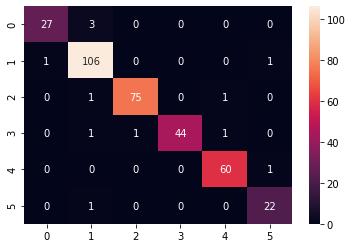

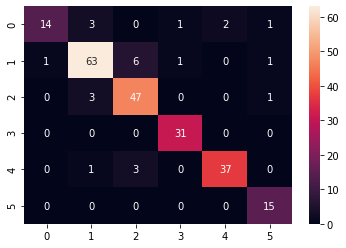

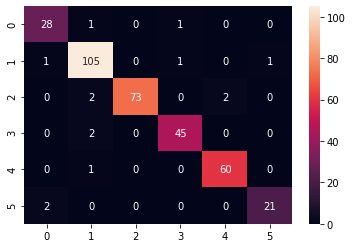

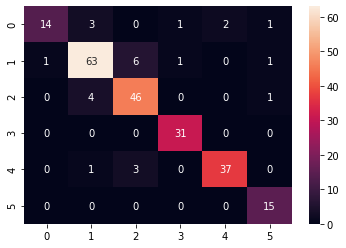

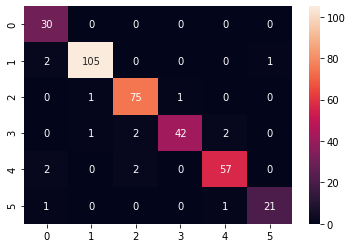

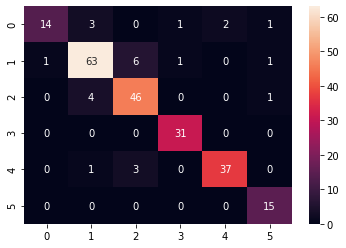

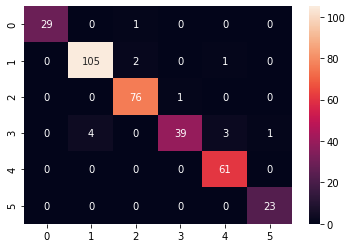

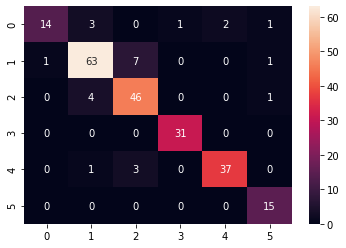

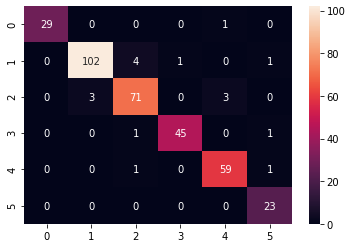

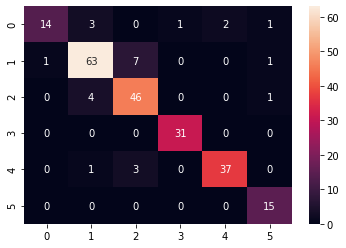

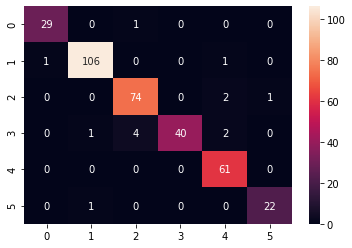

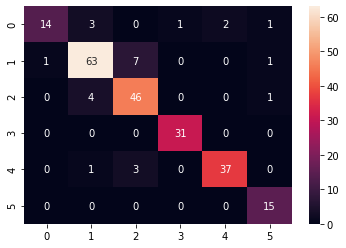

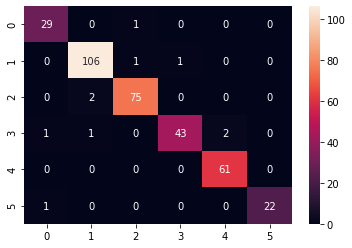

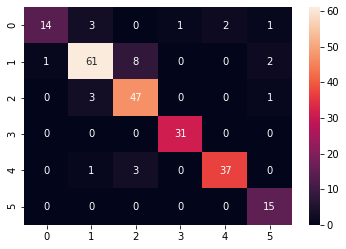

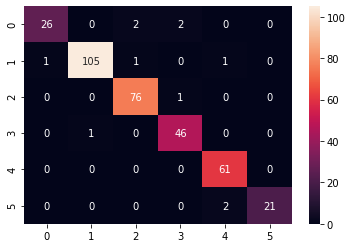

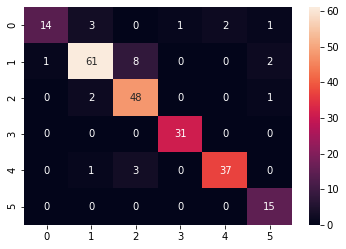

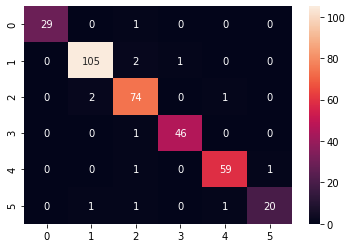

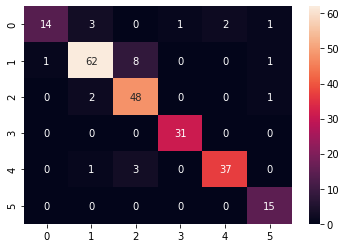

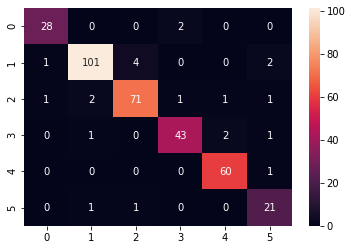

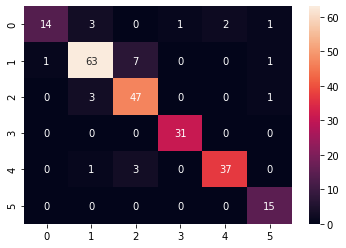

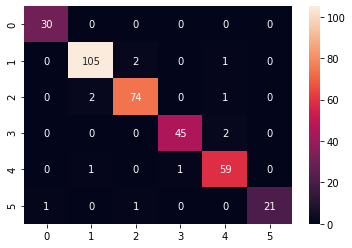

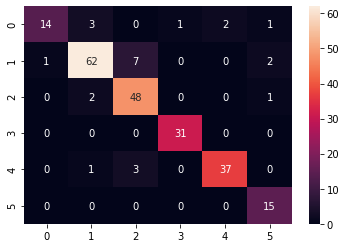

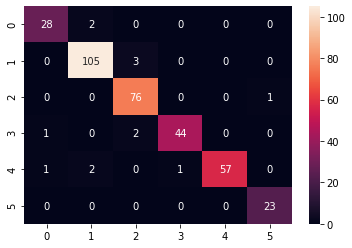

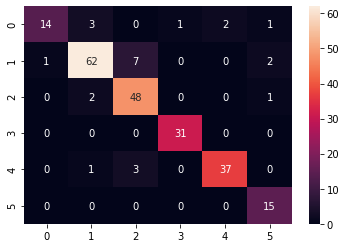

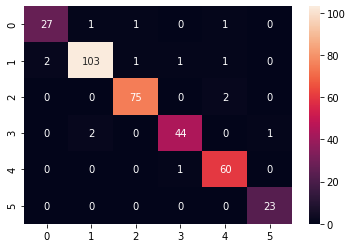

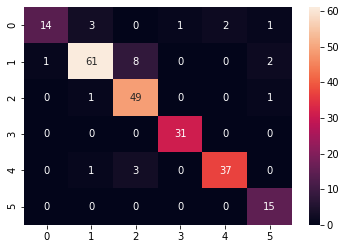

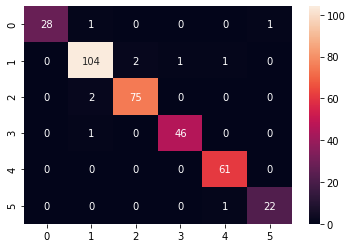

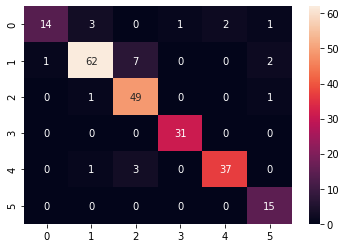

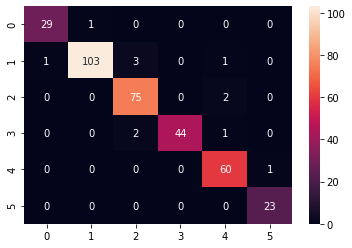

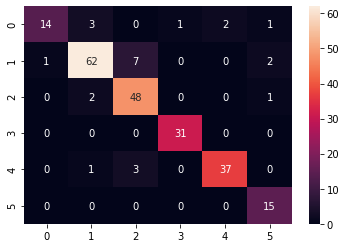

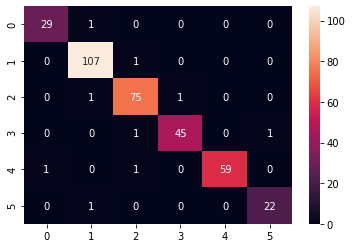

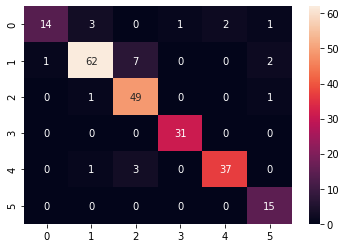

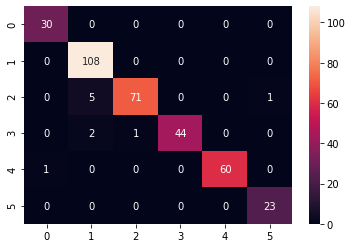

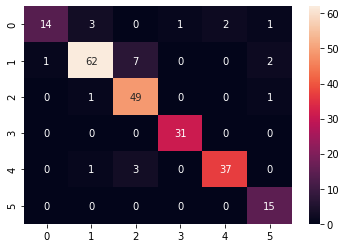

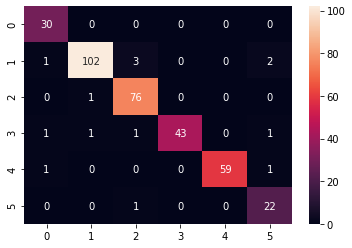

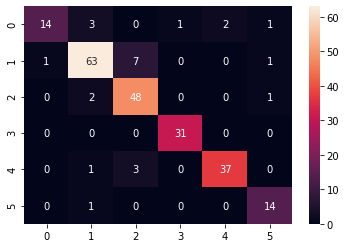

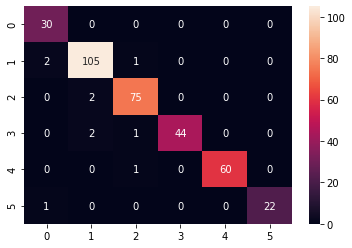

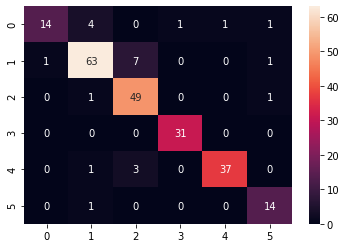

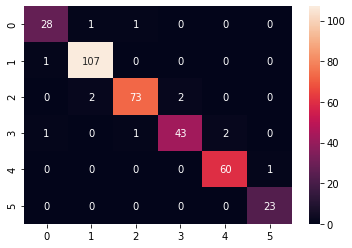

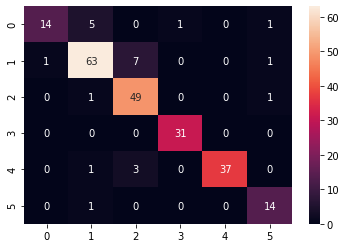

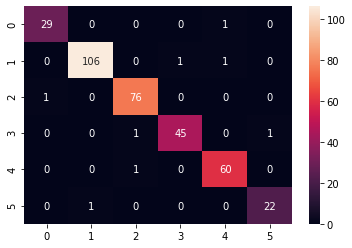

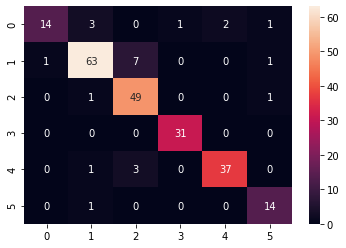

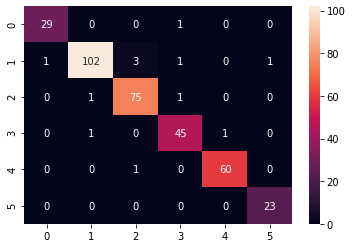

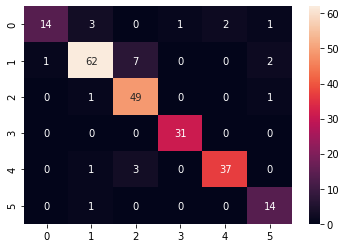

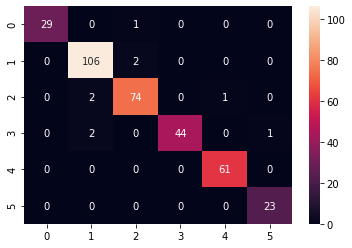

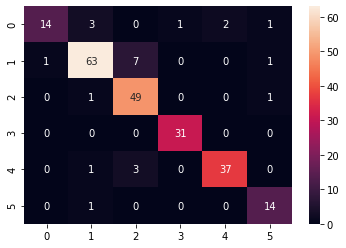

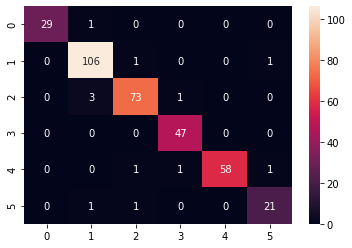

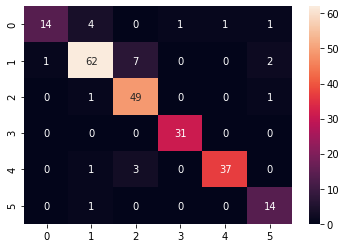

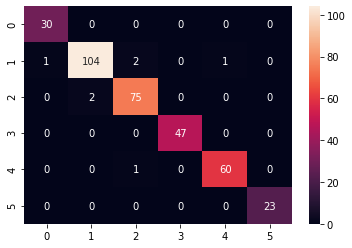

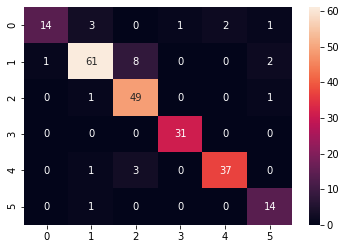

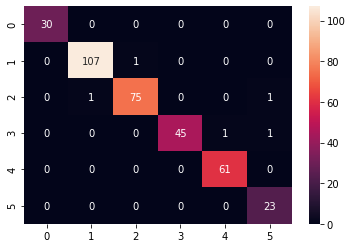

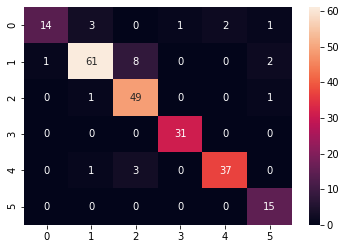

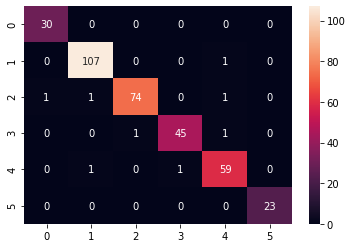

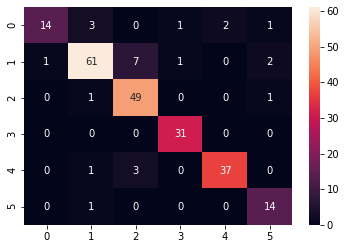

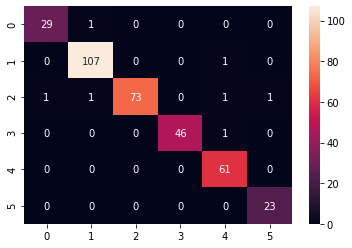

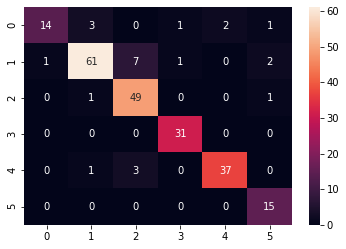

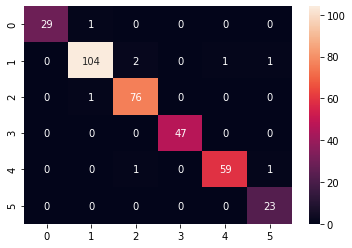

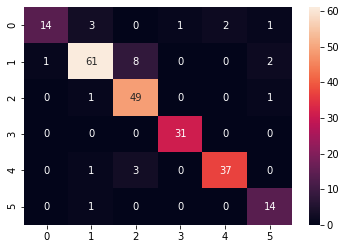

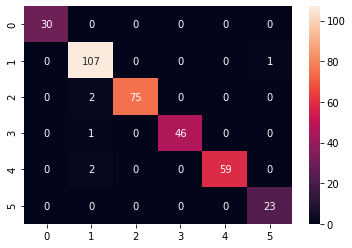

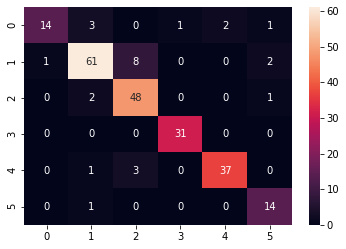

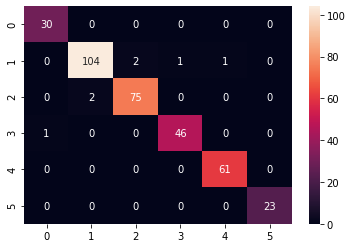

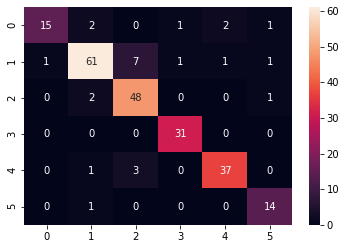

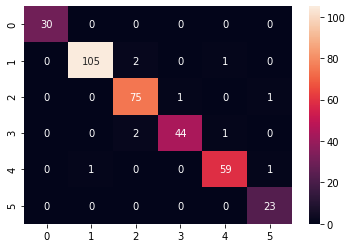

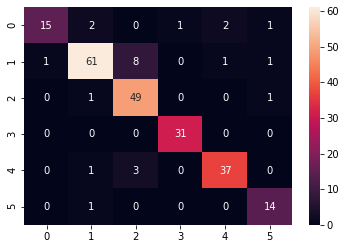

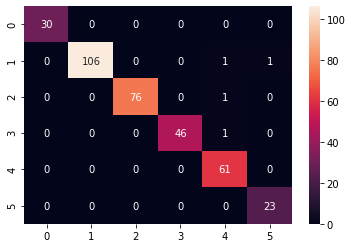

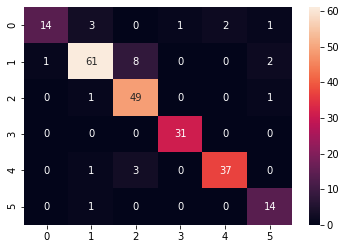

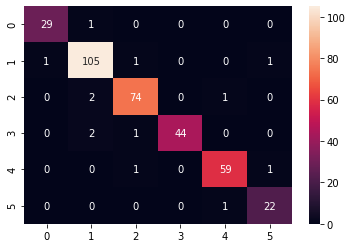

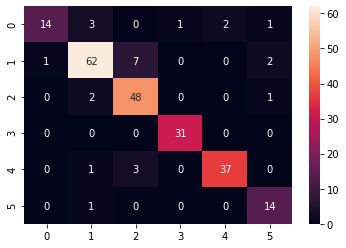

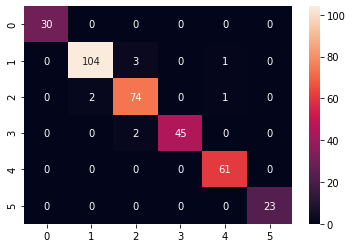

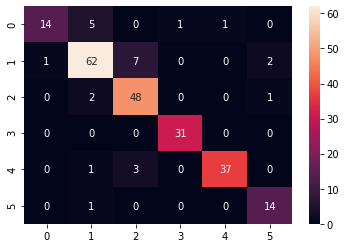

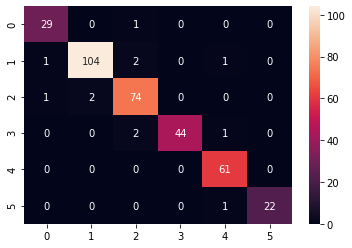

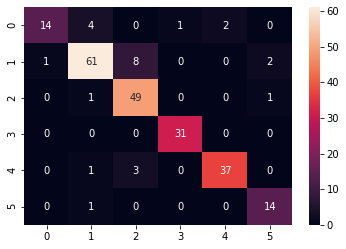

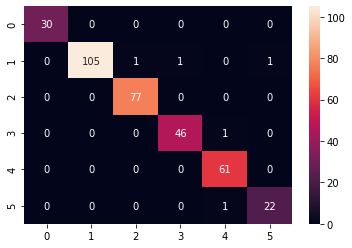

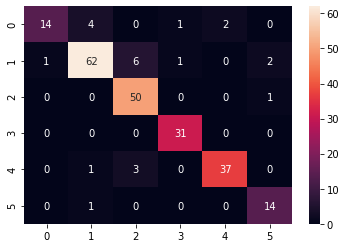

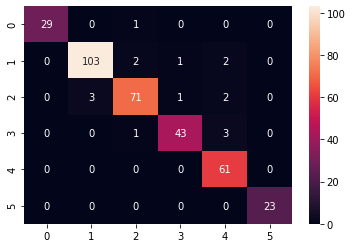

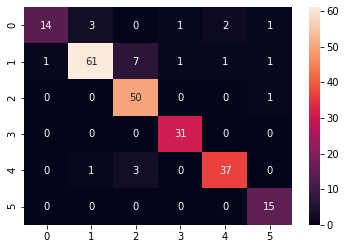

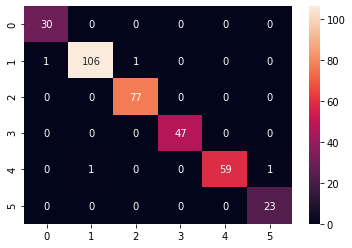

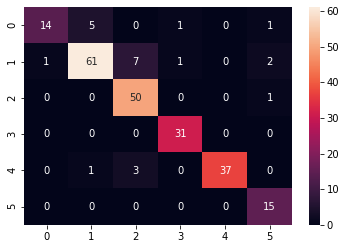

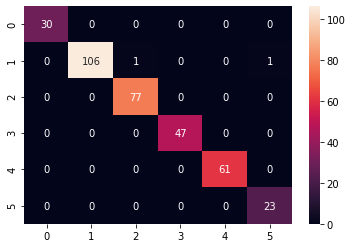

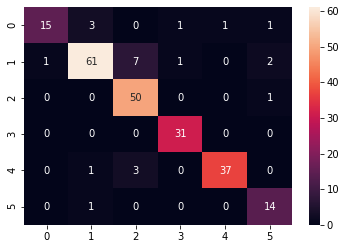

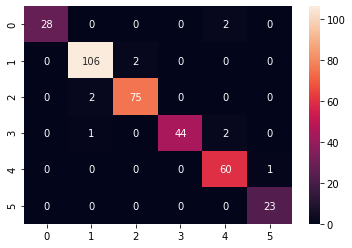

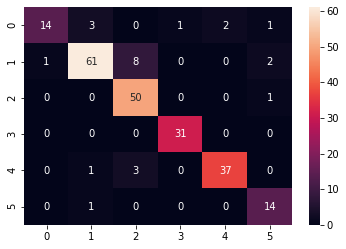

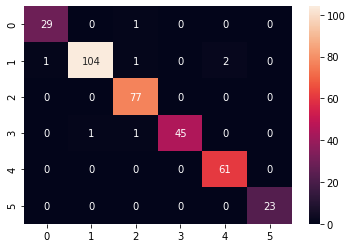

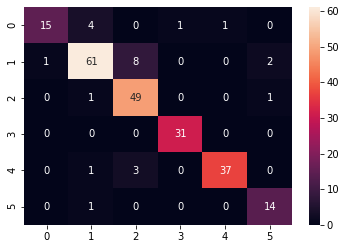

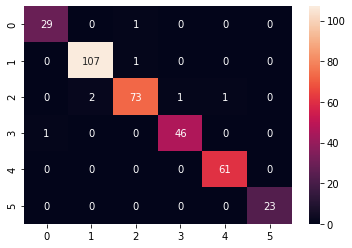

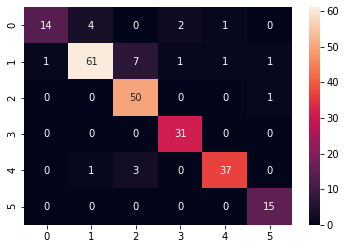

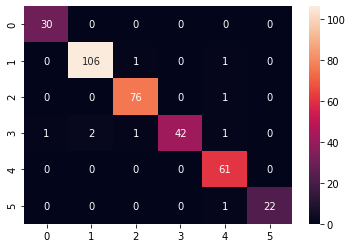

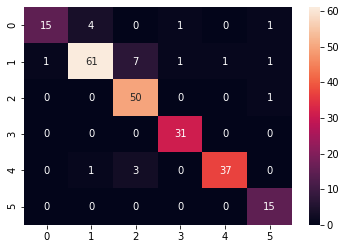

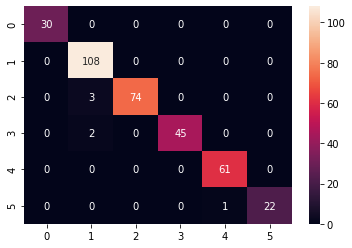

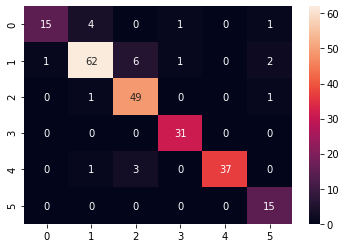

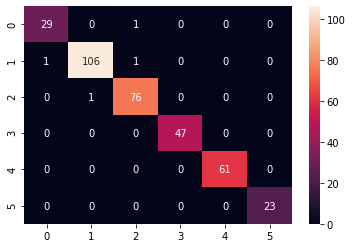

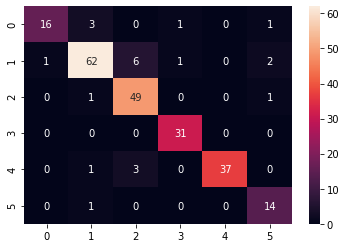

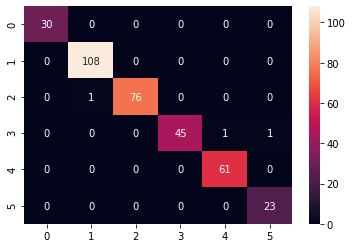

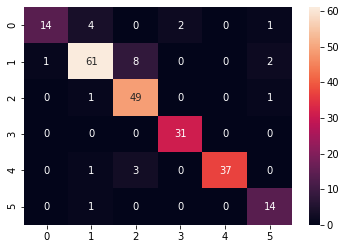

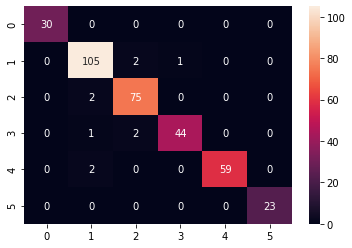

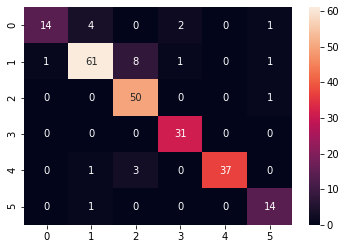

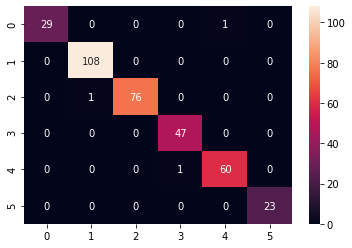

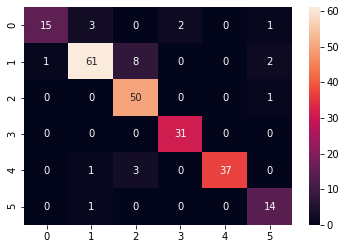

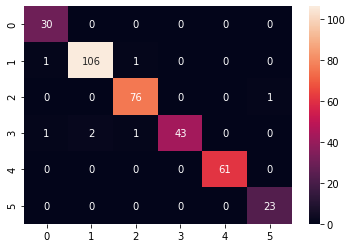

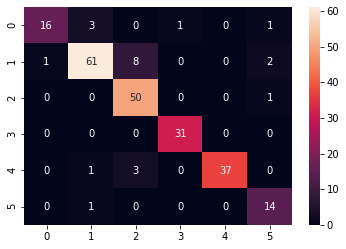

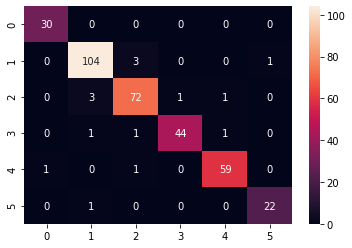

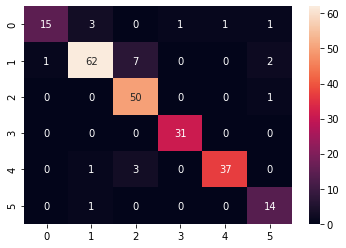

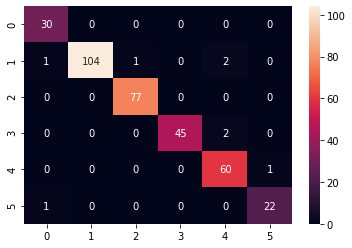

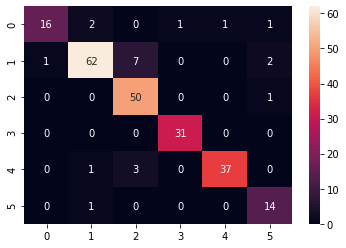

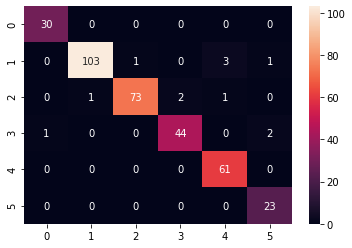

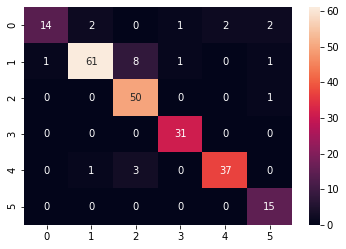

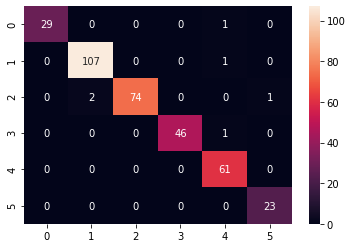

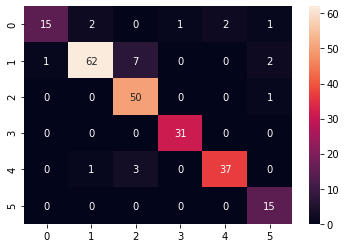

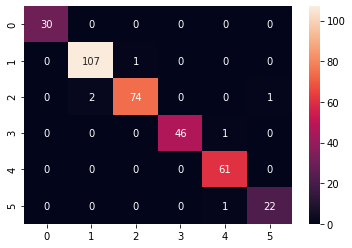

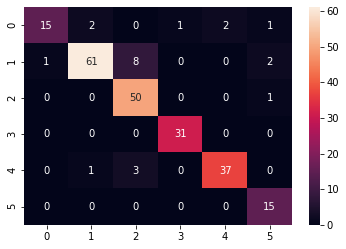

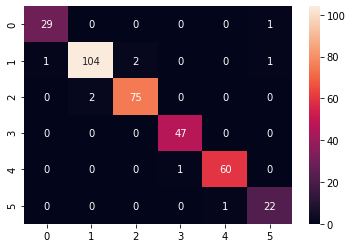

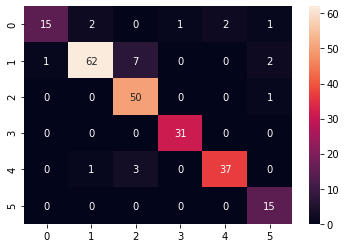

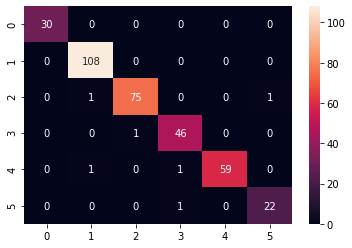

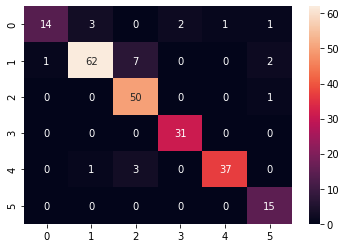

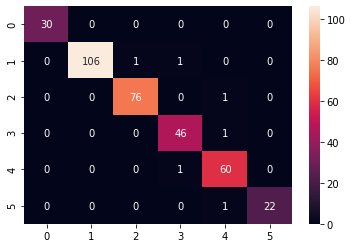

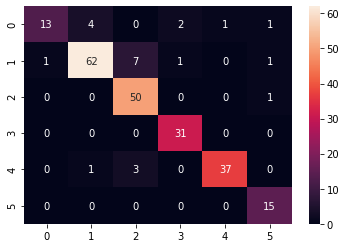

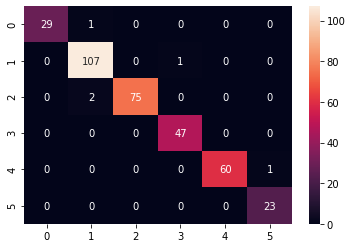

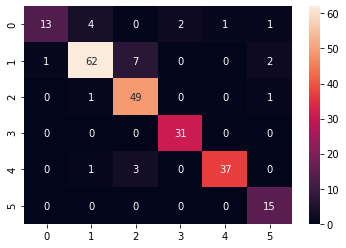

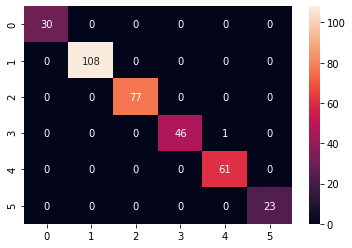

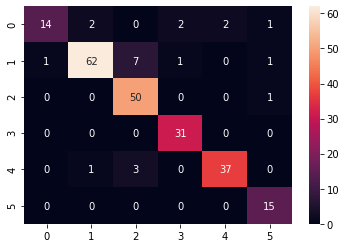

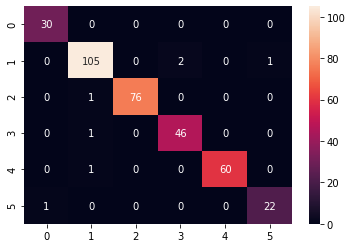

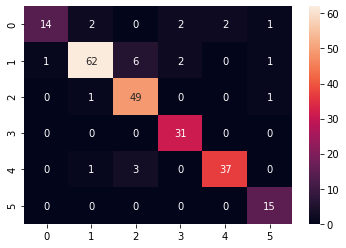

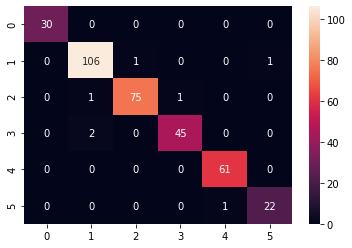

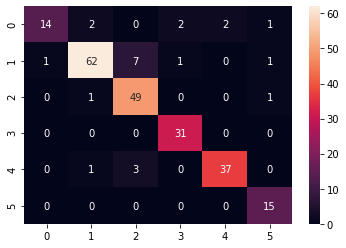

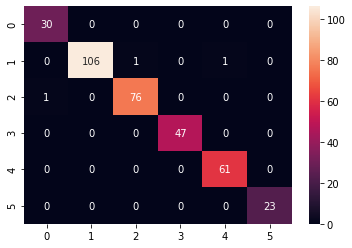

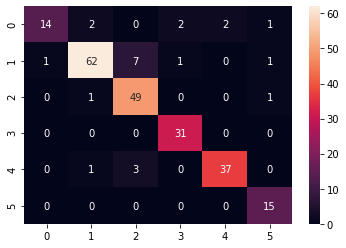

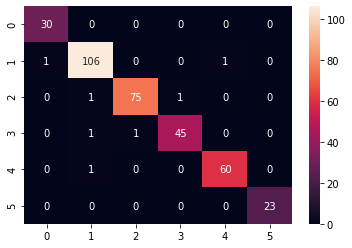

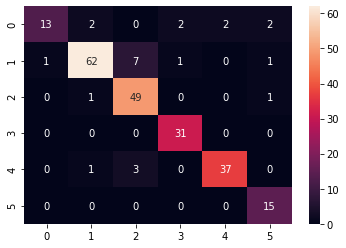

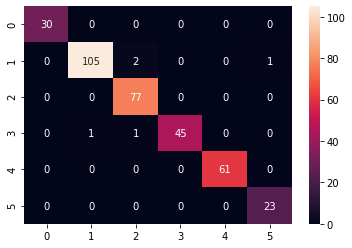

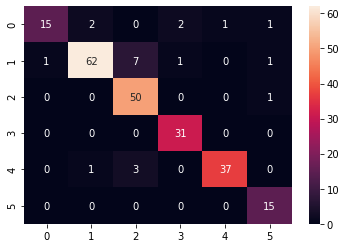

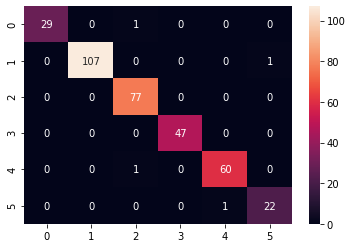

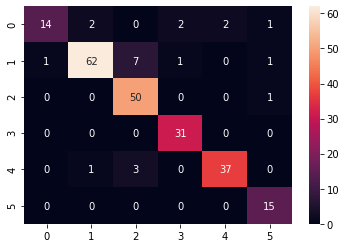

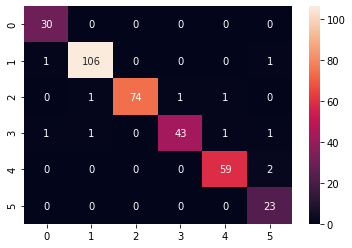

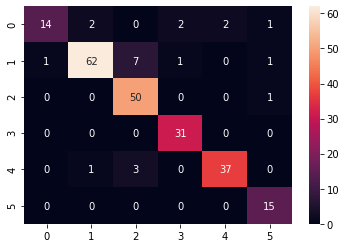

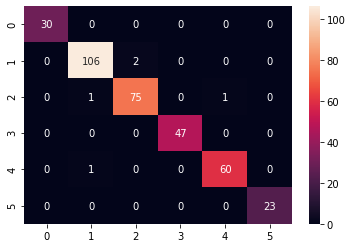

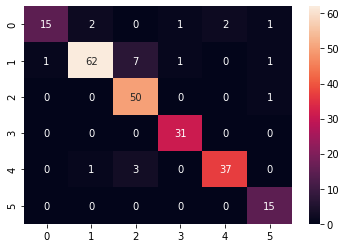

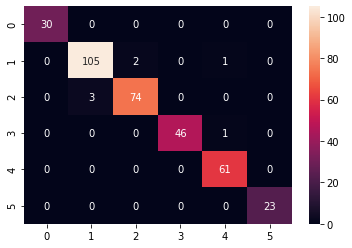

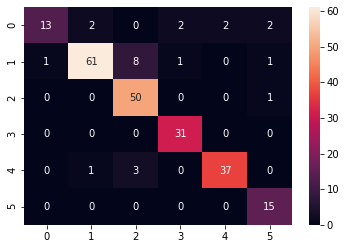

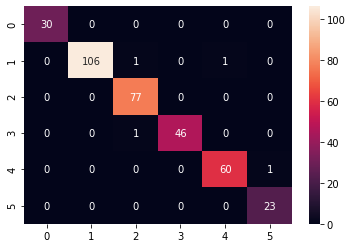

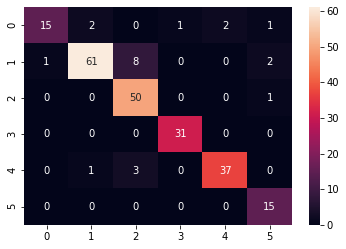

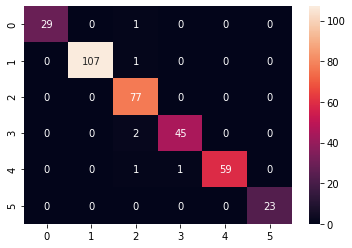

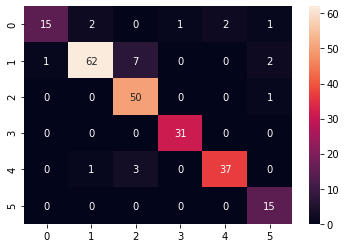

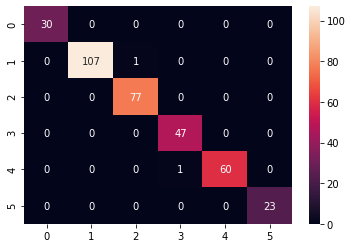

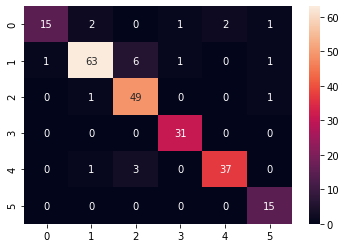

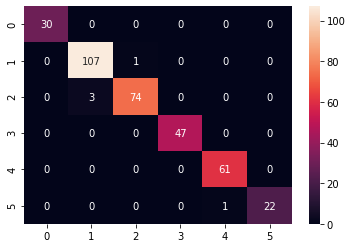

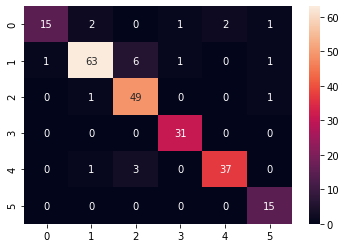

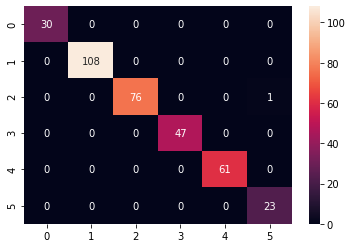

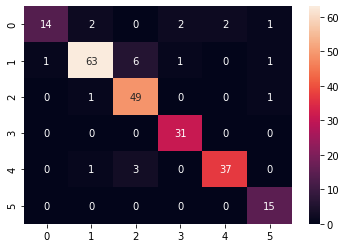

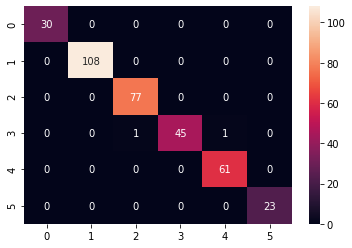

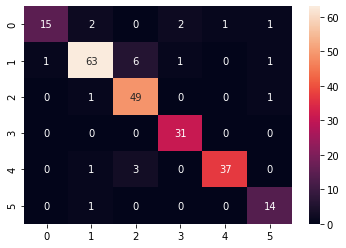

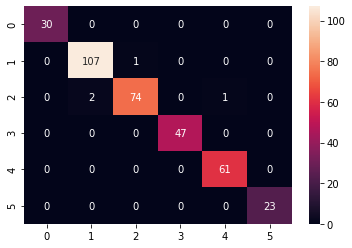

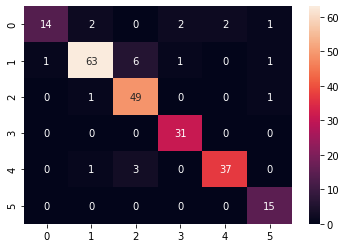

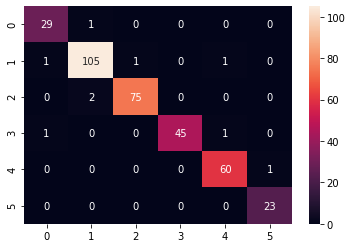

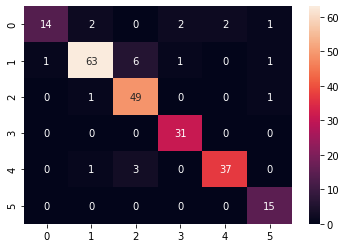

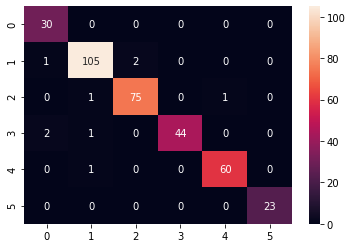

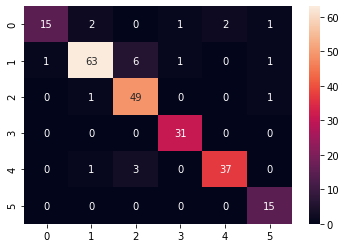

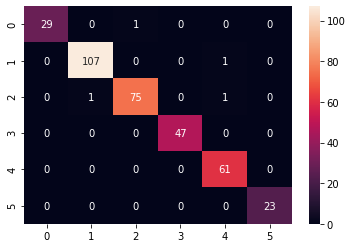

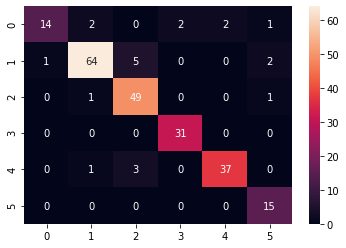

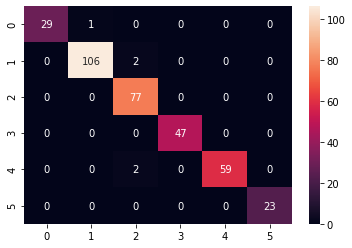

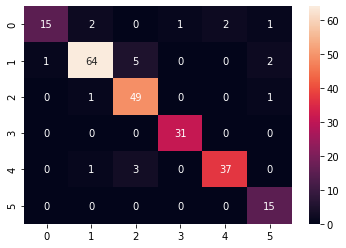

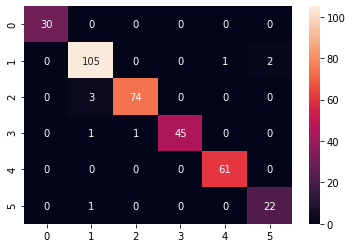

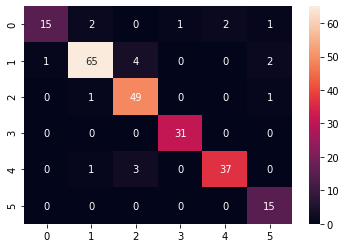

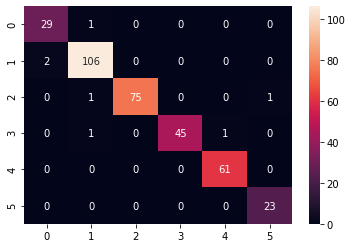

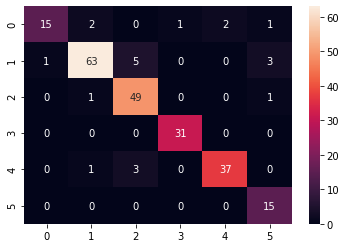

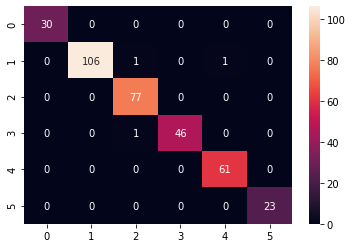

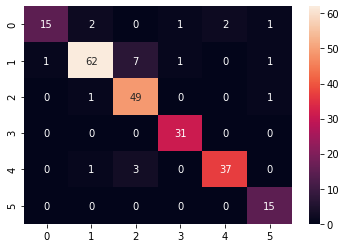

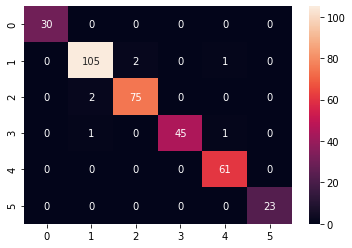

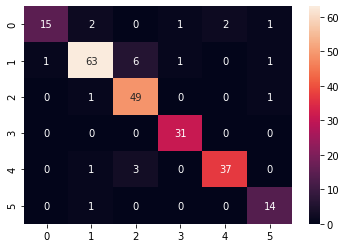

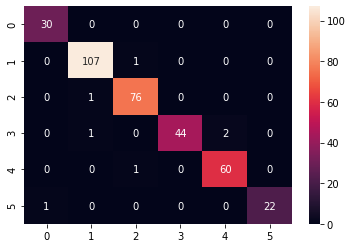

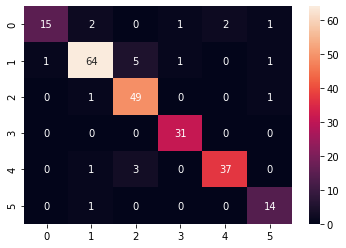

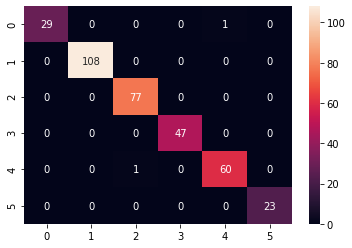

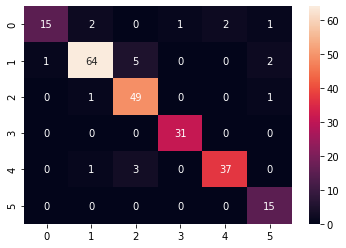

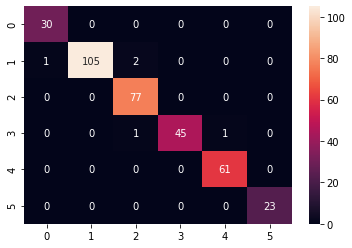

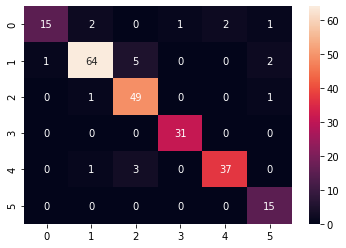

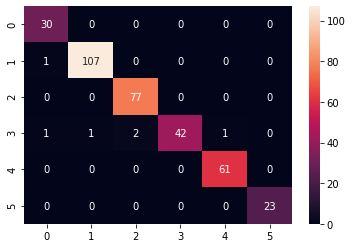

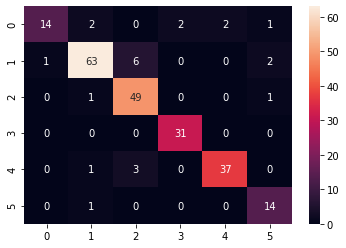

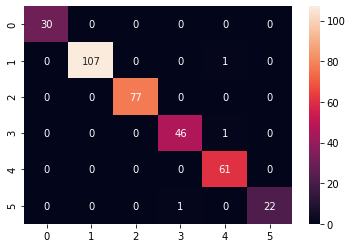

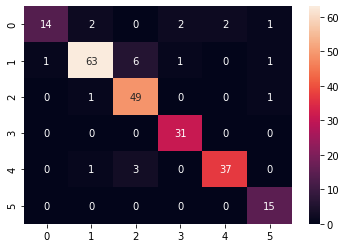

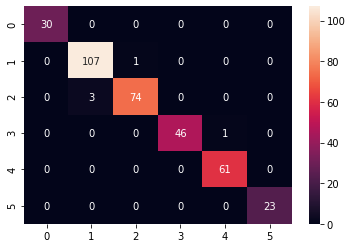

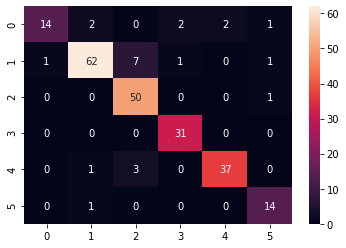

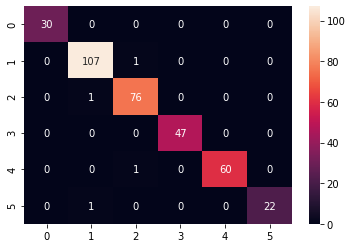

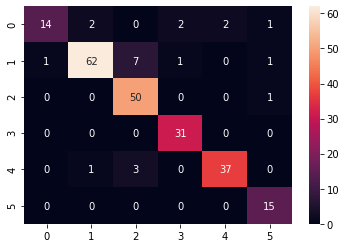

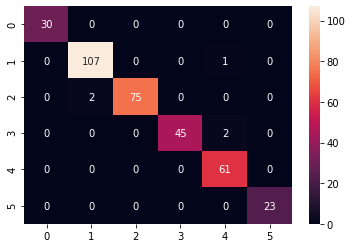

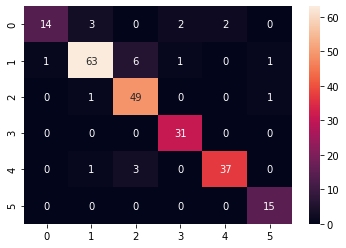

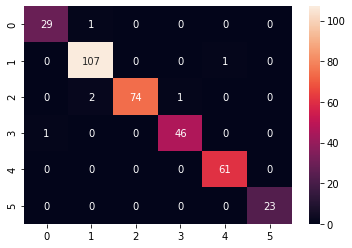

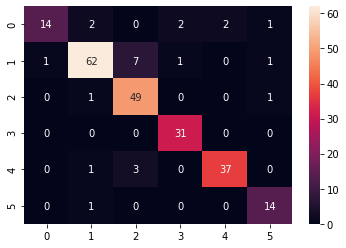

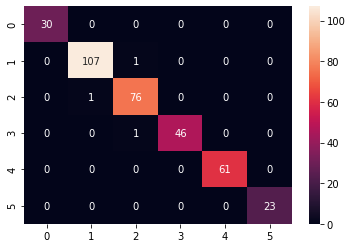

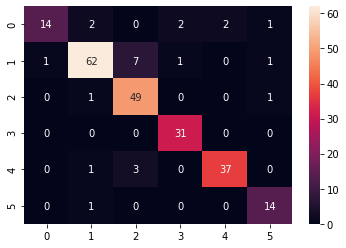

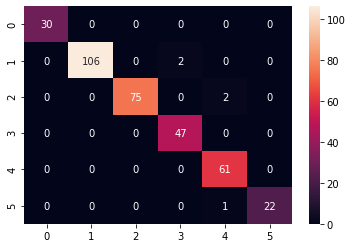

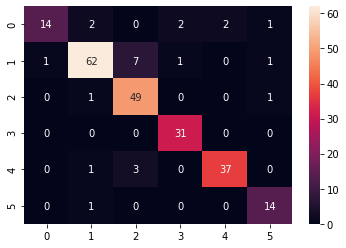

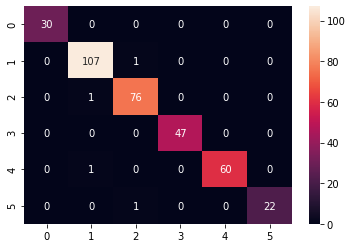

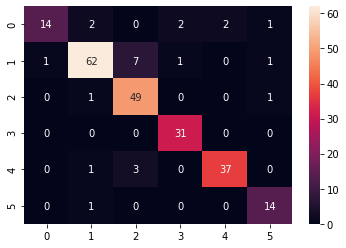

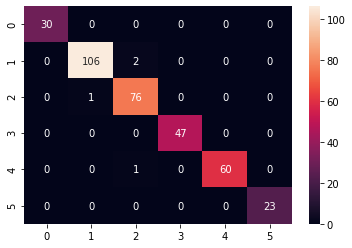

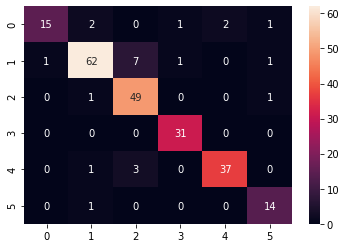

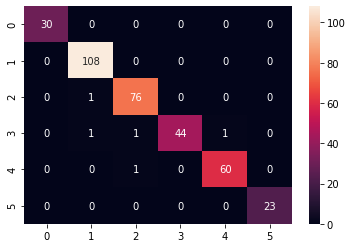

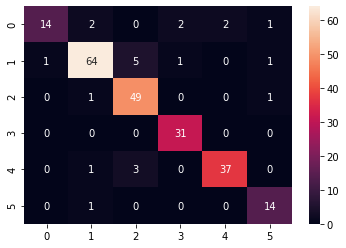

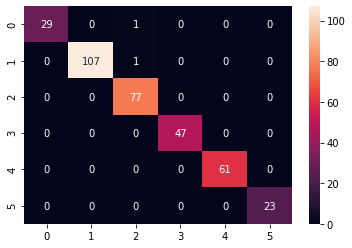

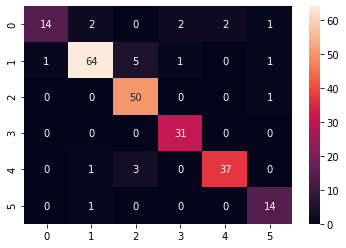

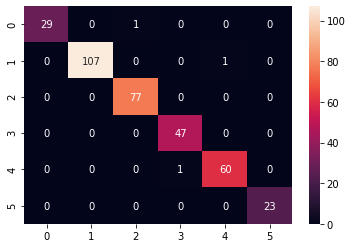

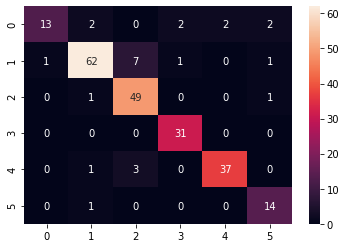

In [141]:
for i in range(1000):
    trainer.run(train_loader)
    train_score = evaluator.run(train_loader)
    score = evaluator.run(test_loader, "val")
    print(f"Batch {i} = Train score: {train_score} | Val Score {score}")


In [ ]:
# Training log:
# Step 1: Gamma + Flips + NOL2 + LR:0.0001 + 10 Epoch with freeze
# Step 2: Remove freeze from the resnet
# Step 3: LR / 10  (8ep)
# Step 4: Full AUG